In [2]:
import pandas as pd

In [3]:
import re

In [4]:
df=pd.read_csv('balanced_20k.csv')

In [5]:
df #currently it is uncleaned

,text,label
0,overdose seroquellexaprowill it fucking kill m...,1
1,holy shit my eyes reddit light mode is a plagu...,0
2,my dad is into some shady shit partialy heard ...,0
3,don't read the spolier \&gt;!reply to this pos...,0
4,"am i depressed, or just periodically 'down'? i...",1
...,...,...
19995,i've become a demon.read my previous posts for...,1
19996,i always end up leaning towards surrealistic w...,1
19997,so i was gonna post some art...but considering...,0
19998,tell me what is your favorite thing you ate to...,0


Text cleaning

1. lowercasing

In [6]:
def lower(s):
    return s.lower()

2.removing punctuation

In [7]:
import string
remove=string.punctuation
def remove_punctuation(s):
    return s.translate(str.maketrans('','',remove))

3. Removing digit

In [8]:
def remove_digits(s):
    return s.translate(str.maketrans('','',string.digits))


4. Extra Space removal

In [9]:
def remove_extra_space(text):
    ans = " ".join(text.split())
    return ans

5. Stop words

In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Download the missing resource
# Load the English Punkt tokenizer
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def remove_stop_words(text):
    # Tokenize the text using the loaded tokenizer
    tokens = tokenizer.tokenize(text)

    # Remove stop words
    clean_tokens = [token for token in tokens if token not in stop_words]

    # Join the clean tokens into a single string
    clean_text = ' '.join(clean_tokens)

    return clean_text



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


6. Removing HTML tags

In [11]:
from bs4 import BeautifulSoup


def remove_html_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()


7. Removing URLS

In [12]:
def remove_url(text):
  return re.sub(r'https?:\S*', '', text)

8. Removing Special Characters

In [13]:
def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    return re.sub(pat, '', text)

In [14]:
df['text']=df['text'].apply(lower)

In [15]:
df['text']=df['text'].apply(remove_punctuation)

In [16]:
df['text']=df['text'].apply(remove_digits)

In [17]:
df['text']=df['text'].apply(remove_extra_space)

In [18]:
df['text']=df['text'].apply(remove_stop_words)

In [19]:
df['text']=df['text'].apply(remove_html_tags)

In [20]:
df['text']=df['text'].apply(remove_url)

In [21]:
df['text']=df['text'].apply(remove_special_characters)

In [22]:
df

,text,label
0,overdose seroquellexaprowill it fucking kill m...,1
1,holy shit my eyes reddit light mode is a plagu...,0
2,my dad is into some shady shit partialy heard ...,0
3,dont read the spolier gtreply to this post or ...,0
4,am i depressed or just periodically down is th...,1
...,...,...
19995,ive become a demonread my previous posts for d...,1
19996,i always end up leaning towards surrealistic w...,1
19997,so i was gonna post some artbut considering th...,0
19998,tell me what is your favorite thing you ate to...,0


Training RNN as dataset is cleaned and pre processed

splitting into training and testing

In [23]:
X=df['text']
Y=df['label']

In [24]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [25]:
print(X_train.shape)
print(Y_train.shape)

(16000,)
(16000,)


In [26]:
print(X_test.shape)
print(Y_test.shape)

(4000,)
(4000,)


In [27]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [28]:
max_features = 10000  # Number of words to consider as features
maxlen = 500  # Cut texts after this number of words (for padding)

In [29]:
tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)            # X_train must be raw text list here
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

In [46]:
# Save it to a file
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [30]:
# Pad sequences to ensure they are of the same length
X_train_padded = sequence.pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_padded = sequence.pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

Building RNN

1. First try simple rnn with single layer 

In [41]:
model = Sequential()
model.add(Embedding(max_features, 32))  # Embedding layer
model.add(SimpleRNN(32))  # Simple RNN layer
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 500, 32)          │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (32, 32)               │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1)                │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 966,341 (3.69 MB)

 Trainable params: 322,113 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 644,228 (2.46 MB)

In [42]:
model.fit(X_train_padded, Y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, Y_test))

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 252s 463ms/step - accuracy: 0.5221 - loss: 0.6912 - val_accuracy: 0.5633 - val_loss: 0.6683
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 213s 427ms/step - accuracy: 0.5332 - loss: 0.6706 - val_accuracy: 0.4855 - val_loss: 0.6678
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 354s 610ms/step - accuracy: 0.5280 - loss: 0.6659 - val_accuracy: 0.5667 - val_loss: 0.6631
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 379s 758ms/step - accuracy: 0.5429 - loss: 0.6605 - val_accuracy: 0.5665 - val_loss: 0.6625
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 273s 543ms/step - accuracy: 0.5323 - loss: 0.6599 - val_accuracy: 0.5665 - val_loss: 0.6654
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 213s 426ms/step - accuracy: 0.5448 - loss: 0.6574 - val_accuracy: 0.5648 - val_loss: 0.6647
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 252s 504ms/step - accuracy: 0.5285 - loss: 0.6584 - val_accuracy: 0.4852 - val_loss: 0.6715
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 227s 454ms/step - accuracy: 0.5279 -

2. Multiple layer RNN

In [44]:
model = Sequential()
model.add(Embedding(max_features, 32))  # Embedding layer
model.add(SimpleRNN(128,return_sequences=True))  # Simple RNN layer 1
model.add(SimpleRNN(128))  # Simple RNN layer 2
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (32, 500, 32)          │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (32, 500, 128)         │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (32, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,120,901 (4.28 MB)

 Trainable params: 373,633 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 747,268 (2.85 MB)

In [46]:
model.fit(X_train_padded, Y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, Y_test))

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 566s 1s/step - accuracy: 0.4963 - loss: 0.7114 - val_accuracy: 0.4865 - val_loss: 0.6967
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 467s 932ms/step - accuracy: 0.5153 - loss: 0.6929 - val_accuracy: 0.5627 - val_loss: 0.6781
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 419s 839ms/step - accuracy: 0.5201 - loss: 0.6844 - val_accuracy: 0.5408 - val_loss: 0.6732
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 343s 685ms/step - accuracy: 0.5288 - loss: 0.6769 - val_accuracy: 0.5443 - val_loss: 0.6807
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 361s 722ms/step - accuracy: 0.5344 - loss: 0.6757 - val_accuracy: 0.5638 - val_loss: 0.6630
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 402s 803ms/step - accuracy: 0.5323 - loss: 0.6668 - val_accuracy: 0.5638 - val_loss: 0.6615
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 338s 677ms/step - accuracy: 0.5354 - loss: 0.6657 - val_accuracy: 0.5725 - val_loss: 0.6627
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1841s 4s/step - accuracy: 0.5557 - loss

Trying a CNN model 

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

max_features = 20000   # vocab size
max_len = 200          # padded sequence length

model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_len))

# Convolution layer: sliding n-gram detector
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Global max pooling: picks strongest signal from each filter
model.add(GlobalMaxPooling1D())

# Dense layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train_padded, Y_train, 
        epochs=10,
        batch_size=32, 
        validation_data=(X_test_padded, Y_test))

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 115ms/step - accuracy: 0.7862 - loss: 0.4423 - val_accuracy: 0.9208 - val_loss: 0.2040
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - accuracy: 0.9445 - loss: 0.1492 - val_accuracy: 0.9317 - val_loss: 0.1859
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - accuracy: 0.9864 - loss: 0.0468 - val_accuracy: 0.9287 - val_loss: 0.2319
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 113ms/step - accuracy: 0.9961 - loss: 0.0155 - val_accuracy: 0.9268 - val_loss: 0.2912
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 58s 116ms/step - accuracy: 0.9980 - loss: 0.0061 - val_accuracy: 0.9258 - val_loss: 0.3388
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 62s 125ms/step - accuracy: 0.9997 - loss: 0.0020 - val_accuracy: 0.9305 - val_loss: 0.3521
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 68s 136ms/step - accuracy: 0.9999 - loss: 7.9649e-04 - val_accuracy: 0.9295 - val_loss: 0.3757
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - accuracy: 0.9996 - los

we can try early stopping 

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

max_features = 20000   # vocab size
max_len = 200          # padded sequence length

model_es = Sequential()
model_es.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_len))

# Convolution layer: sliding n-gram detector
model_es.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Global max pooling: picks strongest signal from each filter
model_es.add(GlobalMaxPooling1D())

# Dense layers for classification
model_es.add(Dense(128, activation='relu'))
model_es.add(Dropout(0.5))
model_es.add(Dense(1, activation='sigmoid'))

model_es.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_es.build(input_shape=(None, max_len))
model_es.summary()



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 196, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_7          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,658,689 (10.14 MB)

 Trainable params: 2,658,689 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping=EarlyStopping(monitor='val_accuracy', patience=3)
history=model_es.fit(X_train_padded, Y_train, 
        epochs=10,
        batch_size=32, 
        validation_data=(X_test_padded, Y_test),
        callbacks=[early_stopping])

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 118ms/step - accuracy: 0.9993 - loss: 0.0027 - val_accuracy: 0.9220 - val_loss: 0.4405
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 130ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9130 - val_loss: 0.4661
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 130ms/step - accuracy: 0.9989 - loss: 0.0038 - val_accuracy: 0.9030 - val_loss: 0.5083
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 67s 133ms/step - accuracy: 0.9909 - loss: 0.0245 - val_accuracy: 0.9165 - val_loss: 0.3920


plot for early stopping model

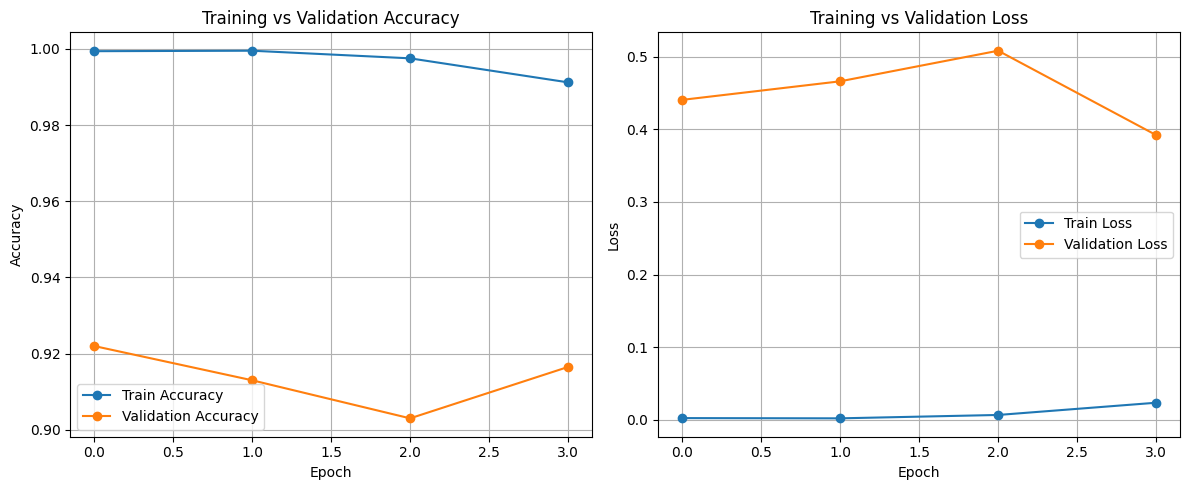

In [58]:
import matplotlib.pyplot as plt


# Accuracy plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#one plot for both

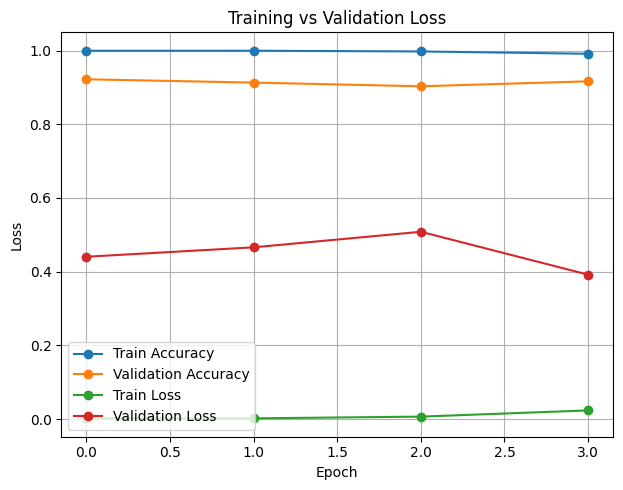

In [59]:
import matplotlib.pyplot as plt


# Accuracy plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot

plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


giving a sentence to test

In [64]:
sent1="i feel crushingly alone and have no one to talk."

In [66]:
import numpy as np

In [70]:
seq=tokenizer.texts_to_sequences([sent1])

seq=np.array(seq)
seq_padded=pad_sequences(seq,maxlen=max_len)

pred=model_es.predict(seq)

label = 1 if pred[0][0] > 0.5 else 0
if label==1:
    print("Predicted class:", "Depression")
else:
    print("Predicted class:", "Non Depression")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted class: Depression


In [77]:

sent2='i am going for a walk early in the morning and also enjoying the fresh breeze'
seq=tokenizer.texts_to_sequences([sent2])

seq=np.array(seq)
seq_padded=pad_sequences(seq,maxlen=max_len)

pred=model_es.predict(seq)

label = 1 if pred[0][0] > 0.5 else 0
if label==1:
    print("Predicted class:", "Depression")
else:
    print("Predicted class:", "Non Depression")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted class: Depression


getting best threshold

In [75]:
# X_val_padded: your validation data, already tokenized & padded
# y_val: true labels

y_pred_prob = model_es.predict(X_test_padded)  # outputs probabilities between 0 and 1
y_pred_prob = y_pred_prob.flatten()          # flatten to 1D array



125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


In [76]:
from sklearn.metrics import f1_score
import numpy as np

best_f1 = 0
best_thresh = 0.5

for thresh in np.arange(0.1, 0.9, 0.01):
    y_pred = (y_pred_prob > thresh).astype(int)
    f1 = f1_score(Y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print("Best threshold:", best_thresh)
print("Best F1-score:", best_f1)


Best threshold: 0.4999999999999998
Best F1-score: 0.6614173228346457


trying out pre trained embeddings 

<h1>1. GLOVE</H1>

We will be following 3 steps to generate model using glove vector.

1.Load Glove model which has 2.2M word embedding, each embedding of length 300
2.Get embedding of those words which are in our corpus and construct a embedding matrix of size - Number of word in data x 300
3.Assign the weight to our first layer and make them non-trainable

In [31]:
#create embedding index
import numpy as np
embedding_index = {}
glove_directory='C:\\Users\\Dell\\Downloads\\glove.2024.wikigiga.200d\\wiki_giga_2024_200_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt'
with open(glove_directory, "r", encoding="utf-8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype="float32")
            embedding_index[word] = coefs
        except ValueError:
            # skip lines with bad formatting
            continue

print("Found %s word vectors." % len(embedding_index))




Found 1287623 word vectors.


create embedding matrix 

In [32]:
embedding_dim = 200  # since you’re using the 200d file
max_features = 20000 # your vocab size from tokenizer

word_index = tokenizer.word_index  # word → index mapping from your dataset

embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    if i < max_features:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [34]:
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Parameters
max_features = 20000   # vocab size (same as tokenizer num_words)
max_len = 200          # padded sequence length
embedding_dim = 200    # because your file is 200d

# Build the embedding matrix (done earlier)
# embedding_matrix = np.zeros((max_features, embedding_dim))
# for word, i in tokenizer.word_index.items():
#     if i < max_features:
#         embedding_vector = embedding_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[i] = embedding_vector

# Define model
model_glove = Sequential()
model_glove.add(Embedding(
    input_dim=max_features,
    output_dim=embedding_dim,
    weights=[embedding_matrix],  # use pretrained embeddings
    input_length=max_len,
    trainable=False              # keep embeddings frozen initially
))

# Convolution layer: sliding n-gram detector
model_glove.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Global max pooling: picks strongest signal from each filter
model_glove.add(GlobalMaxPooling1D())

# Dense layers for classification
model_glove.add(Dense(128, activation='relu'))
model_glove.add(Dropout(0.5))
model_glove.add(Dense(1, activation='sigmoid'))

# Compile
model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build and show summary
model_glove.build(input_shape=(None, max_len))
model_glove.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 200)       │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 196, 128)       │       128,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,144,769 (15.81 MB)

 Trainable params: 144,769 (565.50 KB)

 Non-trainable params: 4,000,000 (15.26 MB)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping=EarlyStopping(monitor='val_accuracy', patience=3,restore_best_weights=True) #with restore best weight sabse high accuracy pe rukega
history=model_glove.fit(X_train_padded, Y_train, 
        epochs=10,
        batch_size=32, 
        validation_data=(X_test_padded, Y_test),
        callbacks=[early_stopping])

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 62s 117ms/step - accuracy: 0.8005 - loss: 0.4283 - val_accuracy: 0.8690 - val_loss: 0.3068
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 69s 137ms/step - accuracy: 0.9182 - loss: 0.2154 - val_accuracy: 0.9122 - val_loss: 0.2342
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 150ms/step - accuracy: 0.9445 - loss: 0.1465 - val_accuracy: 0.9187 - val_loss: 0.2351
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 125ms/step - accuracy: 0.9719 - loss: 0.0831 - val_accuracy: 0.8982 - val_loss: 0.2978
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 62s 124ms/step - accuracy: 0.9819 - loss: 0.0537 - val_accuracy: 0.8978 - val_loss: 0.3465
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 60s 119ms/step - accuracy: 0.9875 - loss: 0.0356 - val_accuracy: 0.9035 - val_loss: 0.3662


Ploty for glove embedding 

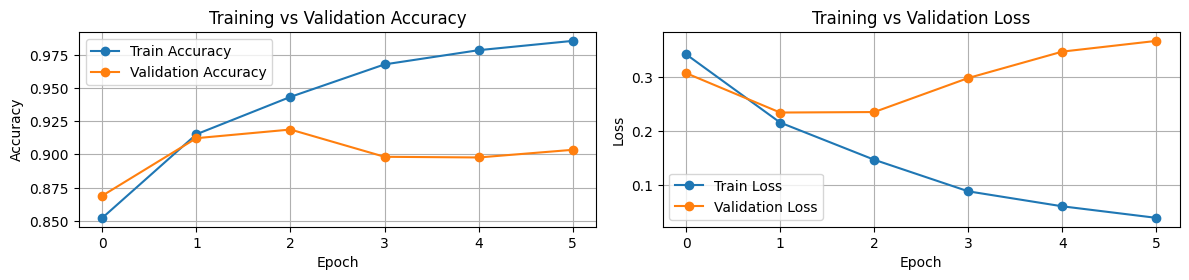

In [36]:
import matplotlib.pyplot as plt


# Accuracy plot
plt.figure(figsize=(12,5))

plt.subplot(2,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(2,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


2. Word2Vec

In [39]:
!pip install gensim

  Using cached gensim-4.3.3-cp311-cp311-win_amd64.whl.metadata (8.2 kB)
  Using cached scipy-1.13.1-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached gensim-4.3.3-cp311-cp311-win_amd64.whl (24.0 MB)
Using cached scipy-1.13.1-cp311-cp311-win_amd64.whl (46.2 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


see this resource->https://www.kaggle.com/code/jiaofenx/imdb-review-word2vec-rnn-tutorial

In [40]:
from gensim.models import KeyedVectors
model_path='C:\\Users\\Dell\\Downloads\\archive (35)\\GoogleNews-vectors-negative300.bin'

In [41]:
# Load word2vec model
word2vec = KeyedVectors.load_word2vec_format(model_path, binary=True)

Build embedding matrix from word2vec

In [43]:
embedding_dim = 300   # depends on the Word2Vec file
max_features = 20000  # same vocab size as tokenizer

embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_features:
        if word in word2vec:
            embedding_matrix[i] = word2vec[word]

In [46]:
model_w2v = Sequential()
model_w2v.add(Embedding(
    input_dim=max_features,
    output_dim=embedding_dim,
    weights=[embedding_matrix],  # Word2Vec embeddings
    input_length=max_len,
    trainable=True             
))

model_w2v.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model_w2v.add(GlobalMaxPooling1D())
model_w2v.add(Dense(128, activation='relu'))
model_w2v.add(Dropout(0.5))
model_w2v.add(Dense(1, activation='sigmoid'))

model_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_w2v.build(input_shape=(None, max_len))
model_w2v.summary()

c:\Users\Dell\anaconda3\envs\streamlitenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 200, 300)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 196, 128)       │       192,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,208,769 (23.68 MB)

 Trainable params: 6,208,769 (23.68 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
early_stopping=EarlyStopping(monitor='val_accuracy', patience=3,restore_best_weights=True) #with restore best weight sabse high accuracy pe rukega

history_w2v = model_w2v.fit(
    X_train_padded, Y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_padded, Y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 230s 444ms/step - accuracy: 0.8236 - loss: 0.3685 - val_accuracy: 0.9185 - val_loss: 0.2129
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 203s 406ms/step - accuracy: 0.9543 - loss: 0.1180 - val_accuracy: 0.9262 - val_loss: 0.2104
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 279s 558ms/step - accuracy: 0.9868 - loss: 0.0413 - val_accuracy: 0.9273 - val_loss: 0.2399
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 290s 491ms/step - accuracy: 0.9961 - loss: 0.0123 - val_accuracy: 0.9305 - val_loss: 0.2886
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 198s 395ms/step - accuracy: 0.9992 - loss: 0.0051 - val_accuracy: 0.9317 - val_loss: 0.3414
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 195s 391ms/step - accuracy: 0.9986 - loss: 0.0046 - val_accuracy: 0.9175 - val_loss: 0.4467
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 216s 431ms/step - accuracy: 0.9950 - loss: 0.0146 - val_accuracy: 0.9275 - val_loss: 0.3763
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 248s 497ms/step - accuracy: 0.9967 -

plot for word2vec

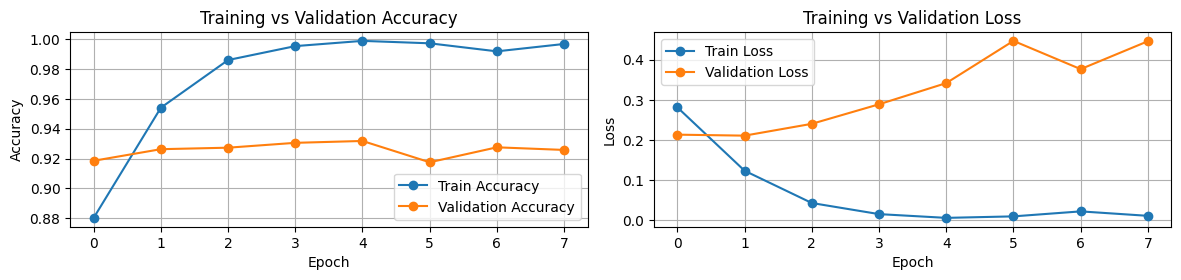

In [48]:
import matplotlib.pyplot as plt


# Accuracy plot
plt.figure(figsize=(12,5))

plt.subplot(2,2,1)
plt.plot(history_w2v.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_w2v.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(2,2,2)
plt.plot(history_w2v.history['loss'], label='Train Loss', marker='o')
plt.plot(history_w2v.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


3. FastText

see this resource->https://www.kaggle.com/code/nikzzzn/lstm-nn-fasttext-embedding

In [31]:
import zipfile
import os

file_path = r"C:\Users\Dell\Downloads\wiki-news-300d-1M.vec\wiki-news-300d-1M.vec"
extract_dir = r"C:\Users\Dell\Downloads\fasttext"

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extracted files:", os.listdir(extract_dir))


Extracted files: ['wiki-news-300d-1M.vec']


In [ ]:
from gensim.models import KeyedVectors
ft_model = KeyedVectors.load_word2vec_format(
    r"C:\Users\Dell\Downloads\fasttext\wiki-news-300d-1M.vec",
    binary=False
)


In [35]:
import numpy as np
embedding_dim = 300   # depends on the fasttext file
max_features = 20000  # same vocab size as tokenizer

embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_features:
        if word in ft_model:
            embedding_matrix[i] = ft_model[word]

In [37]:
max_len=200

In [40]:
model_ft = Sequential()
model_ft.add(Embedding(
    input_dim=max_features,
    output_dim=embedding_dim,
    weights=[embedding_matrix],  # fasttext embeddings
    input_length=max_len,
    trainable=True             
))

model_ft.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model_ft.add(GlobalMaxPooling1D())
model_ft.add(Dense(128, activation='relu'))
model_ft.add(Dropout(0.5))
model_ft.add(Dense(1, activation='sigmoid'))

model_ft.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_ft.build(input_shape=(None, max_len))
model_ft.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 300)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 196, 128)       │       192,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,208,769 (23.68 MB)

 Trainable params: 6,208,769 (23.68 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(monitor='val_accuracy', patience=3,restore_best_weights=True) #with restore best weight sabse high accuracy pe rukega

history_ft = model_ft.fit(
    X_train_padded, Y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_padded, Y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 125s 228ms/step - accuracy: 0.8308 - loss: 0.3694 - val_accuracy: 0.9202 - val_loss: 0.1989
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 119s 238ms/step - accuracy: 0.9638 - loss: 0.1037 - val_accuracy: 0.9380 - val_loss: 0.1716
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 116s 232ms/step - accuracy: 0.9912 - loss: 0.0279 - val_accuracy: 0.9380 - val_loss: 0.2093
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 116s 232ms/step - accuracy: 0.9982 - loss: 0.0086 - val_accuracy: 0.9265 - val_loss: 0.3303
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 127s 253ms/step - accuracy: 0.9992 - loss: 0.0027 - val_accuracy: 0.9392 - val_loss: 0.3028
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 289ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9345 - val_loss: 0.3566
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 109s 218ms/step - accuracy: 0.9974 - loss: 0.0087 - val_accuracy: 0.9317 - val_loss: 0.3092
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 116s 232ms/step - accuracy: 0.9970 -

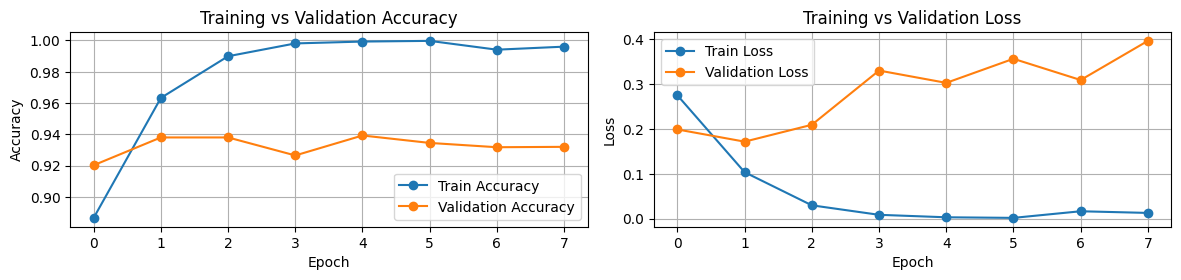

In [43]:
import matplotlib.pyplot as plt


# Accuracy plot
plt.figure(figsize=(12,5))

plt.subplot(2,2,1)
plt.plot(history_ft.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_ft.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(2,2,2)
plt.plot(history_ft.history['loss'], label='Train Loss', marker='o')
plt.plot(history_ft.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Going with fasttext model for app

In [44]:
model_ft.save('rnn_fastext.h5')

In [49]:
text="i do not feel good and i want to die"

In [50]:
import tensorflow as tf
import pickle
import numpy as np

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load the Keras model correctly
model = tf.keras.models.load_model('rnn_fastext.h5')

# Example input text
text = "This is a sample text"

# Convert text to sequence
seq = tokenizer.texts_to_sequences([text])

# Pad the sequence
padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=500)

# Make prediction
pred = model.predict(padded)
print(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
[[0.02113661]]
